In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.spectrum import (
    SpectrumDatasetOnOff,
    SpectrumDataset,
    SpectrumDatasetMaker,
)
from gammapy.modeling import Fit, Parameter
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SpectralModel,
    SkyModel,
    ExpCutoffPowerLawSpectralModel,
)
from gammapy.irf import load_cta_irfs
from gammapy.data import Observation
from gammapy.maps import MapAxis

In [3]:
livetime = 48 * u.h
pointing = SkyCoord(0, 0, unit="deg", frame="galactic")
offset = 0.5 * u.deg
# Reconstructed and true energy axis
energy_axis = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 10), unit="TeV", name="energy", interp="log"
)
energy_axis_true = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 31), unit="TeV", name="energy", interp="log"
)

on_region_radius = Angle("0.11 deg")
on_region = CircleSkyRegion(center=pointing, radius=on_region_radius)

In [4]:
# Define spectral model - a simple Power Law in this case
model_simu = ExpCutoffPowerLawSpectralModel(
    index=2.52,
    amplitude=3.24e-13 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1 * u.TeV,
    lambda_=0.1 * u.Unit("TeV-1"),
    alpha = 1,
)
print(model_simu)
# we set the sky model used in the dataset
model = SkyModel(spectral_model=model_simu)

ExpCutoffPowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.520e+00   nan                nan nan  False
amplitude 3.240e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.000e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True


In [5]:
os.environ['CALDB'] = '/home/rishank/anaconda2/envs/cta/share/caldb/'
!echo $CALDB
!ls $CALDB

/home/rishank/anaconda2/envs/cta/share/caldb/
data


In [6]:
# Load the IRFs
# In this simulation, we use the CTA-1DC irfs shipped with gammapy.
irfs = load_cta_irfs(
    "$CALDB/data/cta/prod3b-v2/bcf/South_z20_50h/irf_file.fits"
)

In [7]:
obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
print(obs)

Info for OBS_ID = 1
- Pointing pos: RA 266.40 deg / Dec -28.94 deg
- Livetime duration: 172800.0 s



In [8]:
# Make the SpectrumDataset
dataset_empty = SpectrumDataset.create(
    e_reco=energy_axis.edges, e_true=energy_axis_true.edges, region=on_region
)
maker = SpectrumDatasetMaker(selection=["aeff", "edisp", "background"])
dataset = maker.run(dataset_empty, obs)

In [9]:
# Set the model on the dataset, and fake
dataset.model = model
dataset.fake(random_state=42)
print(dataset)

SpectrumDataset

    Name                            : 1 

    Total counts                    : 20280 
    Total predicted counts          : nan
    Total background counts         : 20309.41

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 1.73e+05 s

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : cash
    Fit statistic value (-2 log(L)) : nan

    Number of parameters            : 0
    Number of free parameters       : 0




In [10]:
dataset_onoff = SpectrumDatasetOnOff(
    aeff=dataset.aeff,
    edisp=dataset.edisp,
    models=model,
    livetime=livetime,
    acceptance=1,
    acceptance_off=5,
)
dataset_onoff.fake(background_model=dataset.background)
print(dataset_onoff)

SpectrumDatasetOnOff

    Name                            :  

    Total counts                    : 26748 
    Total predicted counts          : 26982.90
    Total off counts                : 102202.00

    Total background counts         : 20440.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.37

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0



In [11]:

%%time

n_obs = 500
datasets = []

for idx in range(n_obs):
    dataset_onoff.fake(random_state=idx, background_model=dataset.background)
    dataset_onoff.name = f"obs_{idx}"
    datasets.append(dataset_onoff.copy())

CPU times: user 2.98 s, sys: 7.71 ms, total: 2.99 s
Wall time: 3 s


In [12]:
print(*datasets, sep = "\n") 

SpectrumDatasetOnOff

    Name                            : obs_0 

    Total counts                    : 26934 
    Total predicted counts          : 26955.50
    Total off counts                : 102065.00

    Total background counts         : 20413.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.34

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1 

    Total counts                    : 26673 
    Total predicted counts          : 26840.30
    Total off counts                : 101489.00

    Total background counts         : 2

SpectrumDatasetOnOff

    Name                            : obs_19 

    Total counts                    : 26675 
    Total predicted counts          : 26845.10
    Total off counts                : 101513.00

    Total background counts         : 20302.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.72

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_20 

    Total counts                    : 26893 
    Total predicted counts          : 26861.90
    Total off counts                : 101597.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_41 

    Total counts                    : 26728 
    Total predicted counts          : 26781.30
    Total off counts                : 101194.00

    Total background counts         : 20238.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.75

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_42 

    Total counts                    : 26696 
    Total predicted counts          : 26884.10
    Total off counts                : 101708.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_63 

    Total counts                    : 26911 
    Total predicted counts          : 26826.90
    Total off counts                : 101422.00

    Total background counts         : 20284.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.35

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_64 

    Total counts                    : 26758 
    Total predicted counts          : 26816.70
    Total off counts                : 101371.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_83 

    Total counts                    : 27104 
    Total predicted counts          : 26839.70
    Total off counts                : 101486.00

    Total background counts         : 20297.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.52

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_84 

    Total counts                    : 26582 
    Total predicted counts          : 26745.90
    Total off counts                : 101017.00

    Total background counts         : 


SpectrumDatasetOnOff

    Name                            : obs_104 

    Total counts                    : 27108 
    Total predicted counts          : 26692.30
    Total off counts                : 100749.00

    Total background counts         : 20149.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.52

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_105 

    Total counts                    : 26661 
    Total predicted counts          : 26888.10
    Total off counts                : 101728.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_123 

    Total counts                    : 26914 
    Total predicted counts          : 26853.30
    Total off counts                : 101554.00

    Total background counts         : 20310.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.19

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_124 

    Total counts                    : 26814 
    Total predicted counts          : 26781.90
    Total off counts                : 101197.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_143 

    Total counts                    : 26539 
    Total predicted counts          : 26855.70
    Total off counts                : 101566.00

    Total background counts         : 20313.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 20.94

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_144 

    Total counts                    : 26829 
    Total predicted counts          : 26830.90
    Total off counts                : 101442.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_163 

    Total counts                    : 26959 
    Total predicted counts          : 26842.70
    Total off counts                : 101501.00

    Total background counts         : 20300.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.09

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_164 

    Total counts                    : 26990 
    Total predicted counts          : 26866.90
    Total off counts                : 101622.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_183 

    Total counts                    : 27056 
    Total predicted counts          : 26881.90
    Total off counts                : 101697.00

    Total background counts         : 20339.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.65

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_184 

    Total counts                    : 26896 
    Total predicted counts          : 26945.70
    Total off counts                : 102016.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_202 

    Total counts                    : 26849 
    Total predicted counts          : 26803.90
    Total off counts                : 101307.00

    Total background counts         : 20261.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.14

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_203 

    Total counts                    : 27019 
    Total predicted counts          : 26905.50
    Total off counts                : 101815.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_221 

    Total counts                    : 26916 
    Total predicted counts          : 26826.90
    Total off counts                : 101422.00

    Total background counts         : 20284.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.59

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_222 

    Total counts                    : 27009 
    Total predicted counts          : 26829.90
    Total off counts                : 101437.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_240 

    Total counts                    : 27013 
    Total predicted counts          : 26914.50
    Total off counts                : 101860.00

    Total background counts         : 20372.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.25

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_241 

    Total counts                    : 26799 
    Total predicted counts          : 26769.10
    Total off counts                : 101133.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_260 

    Total counts                    : 26834 
    Total predicted counts          : 26915.70
    Total off counts                : 101866.00

    Total background counts         : 20373.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.83

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_261 

    Total counts                    : 26884 
    Total predicted counts          : 26671.10
    Total off counts                : 100643.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_280 

    Total counts                    : 26627 
    Total predicted counts          : 26752.70
    Total off counts                : 101051.00

    Total background counts         : 20210.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.76

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_281 

    Total counts                    : 26684 
    Total predicted counts          : 26865.50
    Total off counts                : 101615.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_296 

    Total counts                    : 27120 
    Total predicted counts          : 26905.30
    Total off counts                : 101814.00

    Total background counts         : 20362.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.97

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_297 

    Total counts                    : 27002 
    Total predicted counts          : 26836.50
    Total off counts                : 101470.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_318 

    Total counts                    : 27079 
    Total predicted counts          : 26874.10
    Total off counts                : 101658.00

    Total background counts         : 20331.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.25

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_319 

    Total counts                    : 26782 
    Total predicted counts          : 26813.10
    Total off counts                : 101353.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_338 

    Total counts                    : 26401 
    Total predicted counts          : 26873.30
    Total off counts                : 101654.00

    Total background counts         : 20330.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.02

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_339 

    Total counts                    : 26675 
    Total predicted counts          : 26853.50
    Total off counts                : 101555.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_358 

    Total counts                    : 26942 
    Total predicted counts          : 26819.90
    Total off counts                : 101387.00

    Total background counts         : 20277.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.98

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_359 

    Total counts                    : 26729 
    Total predicted counts          : 26911.10
    Total off counts                : 101843.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_378 

    Total counts                    : 26996 
    Total predicted counts          : 26837.10
    Total off counts                : 101473.00

    Total background counts         : 20294.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.00

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_379 

    Total counts                    : 26917 
    Total predicted counts          : 26874.70
    Total off counts                : 101661.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_399 

    Total counts                    : 26887 
    Total predicted counts          : 26855.30
    Total off counts                : 101564.00

    Total background counts         : 20312.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.92

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_400 

    Total counts                    : 26973 
    Total predicted counts          : 26900.70
    Total off counts                : 101791.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_420 

    Total counts                    : 26841 
    Total predicted counts          : 26863.90
    Total off counts                : 101607.00

    Total background counts         : 20321.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.20

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_421 

    Total counts                    : 26645 
    Total predicted counts          : 26711.70
    Total off counts                : 100846.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_440 

    Total counts                    : 26587 
    Total predicted counts          : 26808.50
    Total off counts                : 101330.00

    Total background counts         : 20266.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.39

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_441 

    Total counts                    : 26680 
    Total predicted counts          : 26753.10
    Total off counts                : 101053.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_460 

    Total counts                    : 26836 
    Total predicted counts          : 26850.90
    Total off counts                : 101542.00

    Total background counts         : 20308.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.86

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_461 

    Total counts                    : 26667 
    Total predicted counts          : 26858.30
    Total off counts                : 101579.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_479 

    Total counts                    : 26964 
    Total predicted counts          : 26886.30
    Total off counts                : 101719.00

    Total background counts         : 20343.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.73

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_480 

    Total counts                    : 26846 
    Total predicted counts          : 26881.10
    Total off counts                : 101693.00

    Total background counts         


SpectrumDatasetOnOff

    Name                            : obs_497 

    Total counts                    : 26650 
    Total predicted counts          : 26906.30
    Total off counts                : 101819.00

    Total background counts         : 20363.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.62

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_498 

    Total counts                    : 27064 
    Total predicted counts          : 26829.70
    Total off counts                : 101436.00

    Total background counts        

Text(0, 0.5, 'No. of observations')

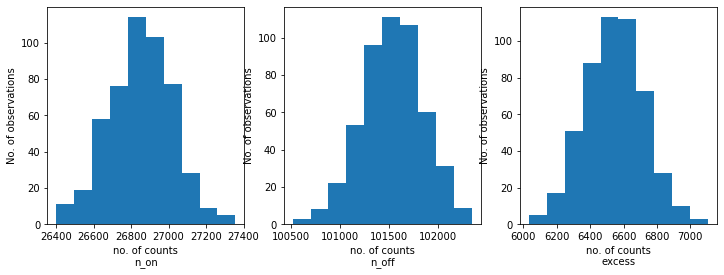

In [13]:

n_on = [dataset.counts.data.sum() for dataset in datasets]
n_off = [dataset.counts_off.data.sum() for dataset in datasets]
excess = [dataset.excess.data.sum() for dataset in datasets]

fix, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].hist(n_on)
axes[0].set_xlabel("no. of counts\nn_on")
axes[0].set_ylabel("No. of observations")
axes[1].hist(n_off)
axes[1].set_xlabel("no. of counts\nn_off")
axes[1].set_ylabel("No. of observations")
axes[2].hist(excess)
axes[2].set_xlabel("no. of counts\nexcess");
axes[2].set_ylabel("No. of observations")

In [14]:

%%time
results = []
for dataset in datasets:
    dataset.models = model.copy()
    fit = Fit([dataset])
    result = fit.optimize()
    results.append(
        {
            "index": result.parameters["index"].value,
            "amplitude": result.parameters["amplitude"].value,
            "lambda_": result.parameters["lambda_"].value,
        }
    )

CPU times: user 1min 47s, sys: 49.2 ms, total: 1min 47s
Wall time: 1min 47s


In [15]:
results

[{'index': 2.4832401660458205,
  'amplitude': 3.472128418877835e-13,
  'lambda_': 0.1274606756858305},
 {'index': 2.5332086862541225,
  'amplitude': 3.075217255236452e-13,
  'lambda_': 0.09424012815413073},
 {'index': 2.5389686519103507,
  'amplitude': 3.2167286250128996e-13,
  'lambda_': 0.13889318916537782},
 {'index': 2.5183908537321034,
  'amplitude': 3.1946519342712916e-13,
  'lambda_': 0.11973070606297374},
 {'index': 2.5475988916811,
  'amplitude': 3.224718122629518e-13,
  'lambda_': 0.09994415630132608},
 {'index': 2.4807709119619297,
  'amplitude': 3.4654857353673174e-13,
  'lambda_': 0.13402461860511863},
 {'index': 2.5476045293109797,
  'amplitude': 3.167050470036428e-13,
  'lambda_': 0.07818667528849135},
 {'index': 2.5106555281620406,
  'amplitude': 3.3795669335054953e-13,
  'lambda_': 0.13214063237429147},
 {'index': 2.4948378695813394,
  'amplitude': 3.243105432115453e-13,
  'lambda_': 0.08739443949208138},
 {'index': 2.557868404194986,
  'amplitude': 3.0319000188377585e

index: 2.5177809121545907 += 0.029415864664360757


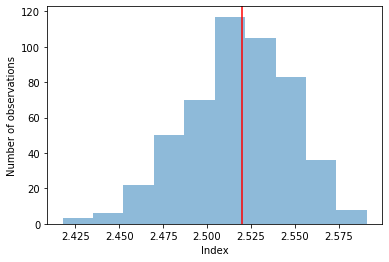

In [16]:
index = np.array([_["index"] for _ in results])
plt.hist(index, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["index"].value, color="red")
plt.xlabel("Index")
plt.ylabel("Number of observations")
print(f"index: {index.mean()} += {index.std()}")

amplitude: 3.263155823509489e-13 += 2.01003154632723e-14


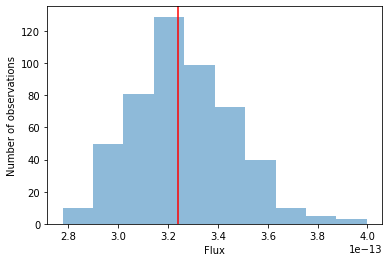

In [17]:
amplitude = np.array([_["amplitude"] for _ in results])
plt.hist(amplitude, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["amplitude"].value, color="red")
plt.xlabel("Flux")
plt.ylabel("Number of observations")
print(f"amplitude: {amplitude.mean()} += {amplitude.std()}")

lambda_: 0.1050003312430654 += 0.02916029769935409


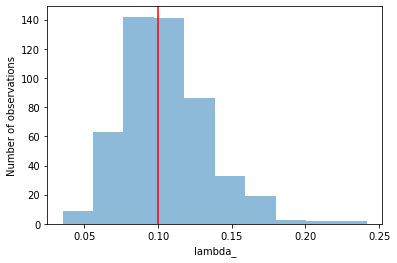

In [18]:
lambda_ = np.array([_["lambda_"] for _ in results])
plt.hist(lambda_, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["lambda_"].value, color="red")
plt.xlabel("lambda_")
plt.ylabel("Number of observations")
print(f"lambda_: {lambda_.mean()} += {lambda_.std()}")